In [1]:
import numpy as np
import cv2
import pywt
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt


In [11]:
def wavelet_decompose(image, wavelet='db5', level=2):
    """ Decompose an image into wavelet coefficients up to the specified level. """
    coeffs = pywt.wavedec2(image, wavelet, mode='periodization', level=level)
    return coeffs

def wavelet_reconstruct(coeffs, wavelet='db5'):
    """ Reconstruct an image from wavelet coefficients. """
    return pywt.waverec2(coeffs, wavelet, mode='periodization')


In [12]:
def pad_coefficients(c1, c2):
    pad_rows = abs(c1.shape[0] - c2.shape[0])
    pad_cols = abs(c1.shape[1] - c2.shape[1])
    
    if c1.shape[0] < c2.shape[0]:
        c1 = np.pad(c1, ((0, pad_rows), (0, 0)), 'symmetric')
    else:
        c2 = np.pad(c2, ((0, pad_rows), (0, 0)), 'symmetric')
    
    if c1.shape[1] < c2.shape[1]:
        c1 = np.pad(c1, ((0, 0), (0, pad_cols)), 'symmetric')
    else:
        c2 = np.pad(c2, ((0, 0), (0, pad_cols)), 'symmetric')
    
    return c1, c2

def advanced_fusion_rule(detail1, detail2):
    variance1 = np.var(detail1)
    variance2 = np.var(detail2)
    
    entropy1 = -np.sum(detail1 * np.log2(detail1 + 1e-10))
    entropy2 = -np.sum(detail2 * np.log2(detail2 + 1e-10))
    
    if variance1 + entropy1 > variance2 + entropy2:
        return detail1
    else:
        return detail2

def fuse_coefficients(coeffs1, coeffs2):
    fused_coeffs = []
    for i, (c1, c2) in enumerate(zip(coeffs1, coeffs2)):
        if isinstance(c1, tuple):  # Detail coefficients
            temp = []
            for detail1, detail2 in zip(c1, c2):
                detail1, detail2 = pad_coefficients(detail1, detail2)
                fused_detail = advanced_fusion_rule(detail1, detail2)
                temp.append(fused_detail)
            fused_coeffs.append(tuple(temp))
        else:  # Approximation coefficients
            c1, c2 = pad_coefficients(c1, c2)
            fused_coeffs.append((c1 + c2) / 2)
    return fused_coeffs

def contrast_enhancement(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

def noise_reduction(image):
    return cv2.fastNlMeansDenoising(image, h=10)


In [13]:
def fusion_process(img1, img2, wavelet='db5', level=2):
    img1, img2 = resize_for_wavelet(img1, img2, level=level)
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    coeffs1 = wavelet_decompose(img1_gray, wavelet, level)
    coeffs2 = wavelet_decompose(img2_gray, wavelet, level)
    
    fused_coeffs = fuse_coefficients(coeffs1, coeffs2)
    
    fused_image = wavelet_reconstruct(fused_coeffs, wavelet)
    fused_image = np.clip(fused_image, 0, 255).astype(np.uint8)
    
    fused_image = contrast_enhancement(fused_image)
    fused_image = noise_reduction(fused_image)
    
    sim1 = ssim(img1_gray, fused_image)
    sim2 = ssim(img2_gray, fused_image)
    
    return fused_image, sim1, sim2


In [14]:
def resize_for_wavelet(image1, image2, level):
    factor = 2**level
    new_width = min(image1.shape[1], image2.shape[1]) // factor * factor
    new_height = min(image1.shape[0], image2.shape[0]) // factor * factor
    
    resized_image1 = cv2.resize(image1, (new_width, new_height), interpolation=cv2.INTER_AREA)
    resized_image2 = cv2.resize(image2, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    return resized_image1, resized_image2


In [15]:
def plot_images(img1, img2, fused_image):
    plt.figure(figsize=(15, 8))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.title('Input Image 1')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.title('Input Image 2')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(fused_image, cmap='gray')
    plt.title('Fused Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


/var/folders/1c/wgg3jchj1vnb_c49fv64srjm0000gn/T/ipykernel_24378/1797817969.py:21: RuntimeWarning: invalid value encountered in log2
  entropy1 = -np.sum(detail1 * np.log2(detail1 + 1e-10))
/var/folders/1c/wgg3jchj1vnb_c49fv64srjm0000gn/T/ipykernel_24378/1797817969.py:22: RuntimeWarning: invalid value encountered in log2
  entropy2 = -np.sum(detail2 * np.log2(detail2 + 1e-10))


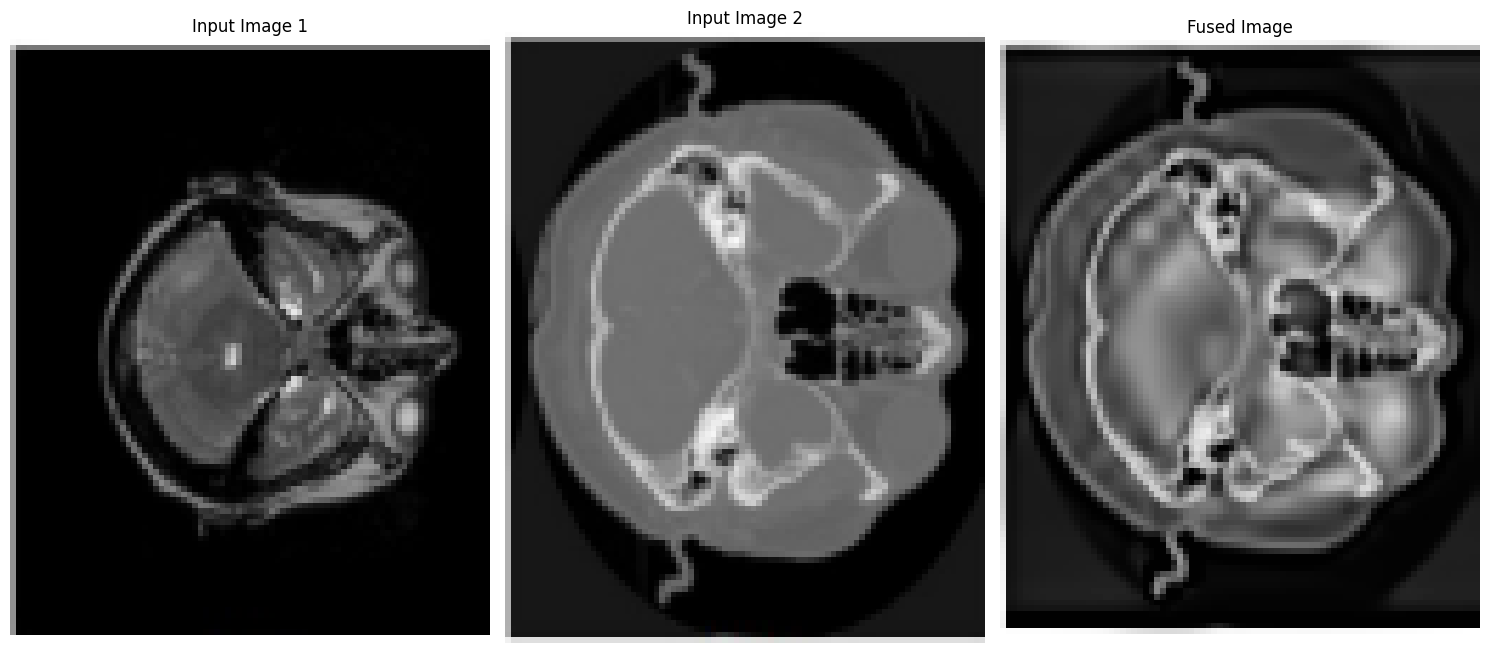

SSIM with img1: 0.1962641279321752
SSIM with img2: 0.6689659594930646


In [16]:
# Example images
img1_path = '/Users/chintubharath/Documents/sdp/ct.png'
img2_path = '/Users/chintubharath/Documents/sdp/mri.png'
# Load images
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

if img1 is None or img2 is None:
    print("Error: One or both image paths are invalid.")
else:
    # Perform the fusion
    fused_image, sim1, sim2 = fusion_process(img1, img2, wavelet='db5', level=2)

    # Display results
    plot_images(img1, img2, fused_image)

    print(f'SSIM with img1: {sim1}')
    print(f'SSIM with img2: {sim2}')
